In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math 
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from numpy import linalg as LA
import math
import re
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import copy
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import keras.backend as K
import cvxopt
from cvxopt import matrix
import numpy as np


In [72]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import cvxopt
from cvxopt import matrix
import numpy as np

class notre_mod(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aon = keras.metrics.SparseCategoricalAccuracy(name="aon")
        self.duree = keras.metrics.SparseCategoricalAccuracy(name="duree")
        self.laon = keras.metrics.SparseCategoricalCrossentropy(name="laon")
        self.lduree = keras.metrics.SparseCategoricalCrossentropy(name="lduree")

    @tf.function
    def compute_grads(self, train, label, model):
        
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            loss1 = self.compiled_loss(label[:, 0],self(train, training=True)[0], regularization_losses=self.losses)  # objective 1 to change
            loss2 = self.compiled_loss(label[:, 1],self(train, training=True)[1], regularization_losses=self.losses)  # objective 1 to change

        grad1 = tape1.gradient(loss1, self.trainable_variables)
        grad1 = [tf.zeros_like(var) if g is None else g for g, var in zip(grad1, self.trainable_variables)]
        grad2 = tape2.gradient(loss2, self.trainable_variables)
        grad2 = [tf.zeros_like(var) if g is None else g for g, var in zip(grad2, self.trainable_variables)]

        grad1 = [tf.reshape(g,[-1]) for g in grad1]
        grad1 = tf.concat(grad1, axis=0)
        grad2 = [tf.reshape(g,[-1]) for g in grad2]
        grad2 = tf.concat(grad2, axis=0)
        return tf.stack([grad1, grad2]), loss1,loss2

    def compute_weight_proportion_epsilon(self,epsilon=1e-3):
        weights = self.trainable_variables
        weights = [np.abs(w) for w in weights if 'kernel' in w.name]
        weights = [w < epsilon for w in weights]
        weights = [np.sum(w) / np.prod(w.shape) for w in weights]
        return np.mean(weights)
    
    def solve_qp(self, vec):
        nobj , dim = vec.shape
        P_temp = np.dot(vec , vec.T)
        P = matrix(np.dot(vec , vec.T).astype(np.double))
        q = matrix(np.zeros(nobj))
        G = matrix(-np.eye(nobj))
        h = matrix(np.zeros(nobj))
        A = matrix(np.ones(nobj).reshape(1,nobj))
        b = matrix(np.ones(1))
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        return np.array(sol['x']).reshape((P_temp.shape[1],))


    def multipleGrad_dual_c(self,vecs):
        sol = self.solve_qp(vecs)
        direction = 0
        for i in range(len(sol)):
            direction += sol[i] * vecs[i]
        return direction

    @tf.function
    def apply_gradient_descent(self, grads, mlp_model):
        grad_shapes = [v.shape for v in mlp_model.trainable_variables]
        shapes_prod = [np.prod(s) for s in grad_shapes]
        grads = tf.split(grads, shapes_prod)
        grads = [tf.reshape(g,s) for g,s in zip(grads,grad_shapes)]

        self.optimizer.apply_gradients(zip(grads, mlp_model.trainable_variables))


    def train_step(self, data):
        x, y = data
        grads, loss1, loss2 = self.compute_grads(x, y, self)
        grads=self.multipleGrad_dual_c(grads.numpy())


        self.apply_gradient_descent(grads, self)
        
        self.aon.update_state(y[:, 0], self(x, training=True)[0])
        self.laon.update_state(y[:, 0], self(x, training=True)[0])
        self.duree.update_state(y[:, 1], self(x, training=True)[1])
        self.lduree.update_state(y[:, 1], self(x, training=True)[1])
        
        
        return {"Atteint_ou_non_loss" : self.laon.result(), "Atteint_ou_non_accuracy" : self.aon.result(), "Duree_hospitalisation_loss" : self.lduree.result(), "Duree_hospitalisation_accuracy" : self.duree.result()}

In [3]:
def convert_to_array(date_str):
    date_str, time_str = date_str.split(' ')
    year, month, day = map(int, date_str.split('-'))
    hour, minute, _ = map(int, time_str.split(':'))
    date_array = [year, month, day, hour, minute]
    return date_array

In [4]:
N_rows = 20000000
labe=pd.read_csv('labevents.csv',nrows=N_rows)

labeinteret=labe.copy()
labeinteret=labeinteret[['subject_id','specimen_id','itemid','charttime','storetime','valuenum','ref_range_lower','ref_range_upper','flag','priority']]
labeinteret['intcharttime']=[int(re.sub(r"\D", "", x)) if isinstance(x,str) else x for x in labeinteret['charttime']]
labeinteret['intstoretime']=[int(re.sub(r"\D", "", x)) if isinstance(x,str) else x for x in labeinteret['storetime']]
labeinteret=labeinteret.drop(columns=['charttime','storetime'],axis=1)
labeinteret=labeinteret.drop(columns=['flag','priority'],axis=1)
labeinteret=labeinteret.dropna()
chartevents= pd.read_csv('chartevents.csv.gz',compression='gzip',nrows=N_rows)
d_items = pd.read_csv('d_items.csv.gz',compression='gzip',nrows=N_rows)
charteventsinteret=chartevents.loc[chartevents['itemid'].isin([220210,224828,220734,220235,220045,220277,220051,223762,225312,225310,225309,228640,227443,223835,220227,220587,225624,225612,225667,226536,220635,225612,227464,220615,225651,225668,225690,220228,227466,220546,227468,225170])]
charteventsinteret=charteventsinteret.sort_values(['subject_id','charttime'])
icustays=pd.read_csv('icustays.csv.gz',compression='gzip',nrows=N_rows)
diag=pd.read_csv('diagnoses_icd.csv',nrows=N_rows)
diagdeux=pd.read_csv('d_icd_diagnoses.csv.gz',compression='gzip',nrows=N_rows)
diag1=diag.loc[diag['icd_code'].isin(['99591','67020','67022','77181','99592'])]
hadmsepsis = list(set(diag1['hadm_id']))

In [5]:
hadm_id_array = np.array(icustays['hadm_id'])
los_array = np.array(icustays['los'])
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(los_array.reshape(-1,1))


B:\Ecole\TSP\2A\Anaconda\envs\cassiop2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
charteventsinteret['sepsis_label'] = charteventsinteret['hadm_id'].isin(hadmsepsis).astype(int)
ens=list(set(charteventsinteret['itemid']))

In [7]:
charteventsinteret['yr']=charteventsinteret['charttime'].apply(lambda x: convert_to_array(x)[0])
charteventsinteret['mo']=charteventsinteret['charttime'].apply(lambda x: convert_to_array(x)[1])
charteventsinteret['day']=charteventsinteret['charttime'].apply(lambda x: convert_to_array(x)[2])
charteventsinteret['hr']=charteventsinteret['charttime'].apply(lambda x: convert_to_array(x)[3])
charteventsinteret['min']=charteventsinteret['charttime'].apply(lambda x: convert_to_array(x)[4])

In [8]:
init=np.zeros(35)
std=np.zeros(35)
for k in range(len(ens)) :
    init[k]=charteventsinteret.loc[charteventsinteret['itemid']==ens[k]]['valuenum'].mean()  
for k in range(len(ens)) :
    std[k]=charteventsinteret.loc[charteventsinteret['itemid']==ens[k]]['valuenum'].std()
init[30]=charteventsinteret['yr'].mean()
init[31]=charteventsinteret['mo'].mean()
init[32]=charteventsinteret['day'].mean()
init[33]=charteventsinteret['hr'].mean()
init[34]=charteventsinteret['min'].mean()
std[30]=charteventsinteret['yr'].std()
std[31]=charteventsinteret['mo'].std()
std[32]=charteventsinteret['day'].std()
std[33]=charteventsinteret['hr'].std()
std[34]=charteventsinteret['min'].std()

In [9]:
data=[]
lbl=[]
lbllos=[]
for subject_id, group in charteventsinteret.groupby('subject_id'):
    for hadm_id, hadm_group in group.groupby('hadm_id'):
        hadmarray=hadm_group.to_numpy()
        n=len(hadmarray)
        l=np.zeros((n,35))
        l[0,ens.index(hadmarray[0,6])]=(hadmarray[0,8]-init[ens.index(hadmarray[0,6])])/std[ens.index(hadmarray[0,6])]
        l[0,30:]=convert_to_array(hadmarray[0,4])
        for k in range(1,n) :
            x = np.copy(l[k-1])
            x[ens.index(hadmarray[k,6])]=(hadmarray[k,8]-init[ens.index(hadmarray[k,6])])/std[ens.index(hadmarray[k,6])]
            l[k]=np.copy(x)
            l[k,30:]=(convert_to_array(hadmarray[k,4])-init[30:])/std[30:]
        data.append(l)
        lbl.append(hadm_id in hadmsepsis)
        lbllos.append(kmeans3.labels_[hadm_id_array.tolist().index(hadm_id)])
data=np.array(data)
lbl=np.array(lbl)
lbl=lbl.astype(int)
lbllos=np.array(lbllos)

C:\Users\Robert\AppData\Local\Temp\ipykernel_11636\3940164430.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array(data)


In [10]:
databatchified=[]
lblbatchified=[]
lbllosbatchified=[]
for i in range(len(data)):
    x=data[i]
    n=len(x)
    for k in range(n//20):
        databatchified.append(x[k*20:(k+1)*20])
        lblbatchified.append(lbl[i])
        lbllosbatchified.append(lbllos[i])

In [11]:
databatchified=np.array(databatchified)
lblbatchified=np.array(lblbatchified)
lblbatchified=lblbatchified.astype(int)
lbllosbatchified=np.array(lbllosbatchified)

In [12]:
positive_indices = np.where(lblbatchified == 1)[0]

# Calculate the desired number of data points labeled as 1
desired_positive_count = int(0.2 * len(databatchified))

# Randomly select data points with label 1 to keep
selected_positive_indices = positive_indices

# Find the indices where labels are equal to 0
negative_indices = np.where(lblbatchified == 0)[0]

# Calculate the desired number of data points labeled as 0
desired_negative_count = len(selected_positive_indices)

# Randomly select data points with label 0 to keep
selected_negative_indices = np.random.choice(negative_indices, size=desired_negative_count, replace=False)

# Combine the selected indices for positive and negative labels
selected_indices = np.concatenate((selected_positive_indices, selected_negative_indices))

# Filter the data and labels based on the selected indices
cleaned_data = databatchified[selected_indices]
cleaned_labels = lblbatchified[selected_indices]
cleaned_labelslos = lbllosbatchified[selected_indices]

label_finaux=[]
for i in range(len(cleaned_labelslos)):
    label_finaux.append([cleaned_labels[i], cleaned_labelslos[i]])
label_finaux=np.array(label_finaux)

In [13]:
train_data, test_data, train_lbl, test_lbl = train_test_split(cleaned_data, label_finaux, test_size=0.2)

In [14]:
def positional_encoding_1d(d_model: int, seq_len: int):
    pe = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
            pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
    return pe

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    #inputs += positional_encoding_1d(inputs.shape[-1], inputs.shape[1])
    # Normalization and Attention
    #x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    #x += positional_encoding_1d(x.shape[-1], x.shape[1])
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [73]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    dense_1 = layers.Dense(2, activation="softmax", name="Atteint_ou_non")(x)
    dense_2 = layers.Dense(3, activation="softmax", name="Duree_hospitalisation")(x)
    return notre_mod(inputs, outputs=[dense_1, dense_2])

In [74]:
input_shape = train_data.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.1,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),run_eagerly=True
)



hist=model.fit(
    train_data,
    train_lbl,
    epochs=10,
    batch_size=16,
)

Epoch 1/10
1323/1323 [==============================] - 962s 722ms/step - Atteint_ou_non_loss: 0.7488 - Atteint_ou_non_accuracy: 0.5246 - Duree_hospitalisation_loss: 1.1594 - Duree_hospitalisation_accuracy: 0.3848
Epoch 2/10
1323/1323 [==============================] - 951s 719ms/step - Atteint_ou_non_loss: 0.7112 - Atteint_ou_non_accuracy: 0.5983 - Duree_hospitalisation_loss: 1.1131 - Duree_hospitalisation_accuracy: 0.4792
Epoch 3/10
1323/1323 [==============================] - 959s 724ms/step - Atteint_ou_non_loss: 0.6856 - Atteint_ou_non_accuracy: 0.6539 - Duree_hospitalisation_loss: 0.9888 - Duree_hospitalisation_accuracy: 0.5405
Epoch 4/10
1323/1323 [==============================] - 956s 722ms/step - Atteint_ou_non_loss: 0.6660 - Atteint_ou_non_accuracy: 0.6668 - Duree_hospitalisation_loss: 0.9625 - Duree_hospitalisation_accuracy: 0.5619
Epoch 5/10
1323/1323 [==============================] - 960s 726ms/step - Atteint_ou_non_loss: 0.6524 - Atteint_ou_non_accuracy: 0.6716 - Duree_

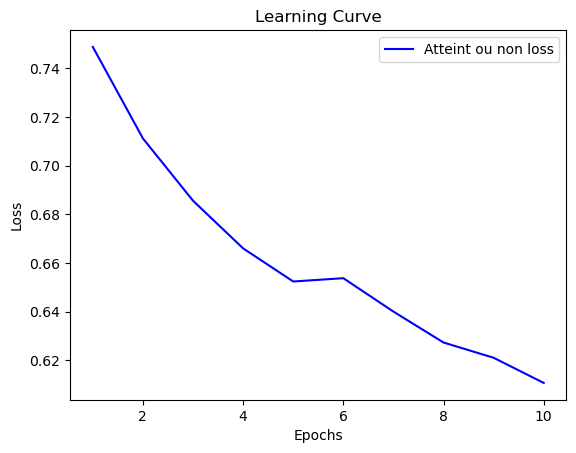

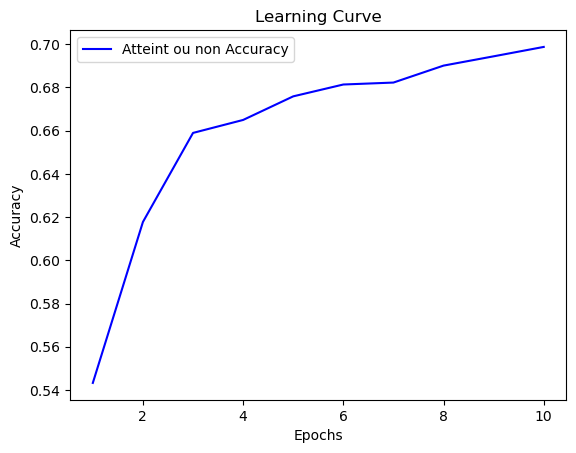

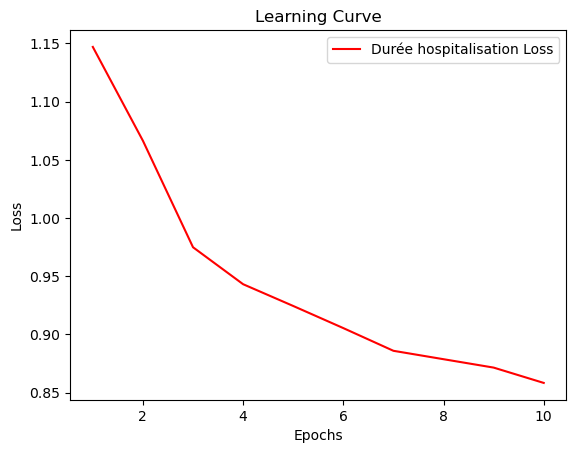

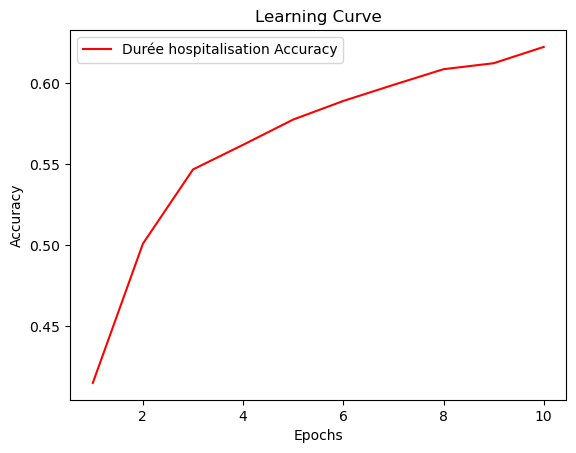

In [76]:
history=hist.history

# Plotting the learning curve
epochs = range(1, len(history['Atteint_ou_non_loss']) + 1)

plt.plot(epochs, history['Atteint_ou_non_loss'], 'b', label='Atteint ou non loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history['Atteint_ou_non_accuracy'], 'b', label='Atteint ou non Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(epochs, history['Duree_hospitalisation_loss'], 'r', label='Durée hospitalisation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history['Duree_hospitalisation_accuracy'], 'r', label='Durée hospitalisation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()